# Initial data

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install pyarrow

In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
os.listdir('/content/drive/My Drive/HAMLAB - private')

['A_components.parquet',
 'A_events.parquet',
 'B_events.parquet',
 'B_components.parquet',
 'C_events.parquet',
 'D_events.parquet',
 'C_components.parquet',
 'D_components.parquet',
 'M4 Neural network.ipynb']

In [6]:
path = '/content/drive/My Drive/HAMLAB - private'

try:
  df_a_events = pd.read_parquet(os.path.join(path, 'A_events.parquet'))
  df_a_components = pd.read_parquet(os.path.join(path, 'A_components.parquet'))
  df_b_events = pd.read_parquet(os.path.join(path, 'B_events.parquet'))
  df_b_components = pd.read_parquet(os.path.join(path, 'B_components.parquet'))
  df_c_events = pd.read_parquet(os.path.join(path, 'C_events.parquet'))
  df_c_components = pd.read_parquet(os.path.join(path, 'C_components.parquet'))
  df_d_events = pd.read_parquet(os.path.join(path, 'D_events.parquet'))
  df_d_components = pd.read_parquet(os.path.join(path, 'D_components.parquet'))

  print("Success")

except FileNotFoundError:
  print("No file")
except Exception as e:
  print(f"Error: {e}")


Success


In [7]:
def merge_events_components(events_df, components_df):
    # Drop common columns from events_df (except 'Attack ID')
    common_columns = set(events_df.columns) & set(components_df.columns)
    common_columns.discard("Attack ID")

    events_df_clean = events_df.drop(columns=common_columns)

    # Merge at Attack ID
    merged_df = pd.merge(
        components_df,
        events_df_clean,
        on="Attack ID",
        how="inner"
    )

    return merged_df

In [8]:
df_a = merge_events_components(df_a_events, df_a_components)
df_b = merge_events_components(df_b_events, df_b_components)
df = pd.concat([df_a, df_b], ignore_index=True)

c_df = merge_events_components(df_c_events, df_c_components)
d_df = merge_events_components(df_d_events, df_d_components)

In [9]:
df.info()

c_df.info()
d_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820091 entries, 0 to 1820090
Data columns (total 17 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   Attack ID            int64 
 1   Detect count         int64 
 2   Card                 object
 3   Victim IP            object
 4   Port number          int64 
 5   Attack code          object
 6   Significant flag     int64 
 7   Packet speed         int64 
 8   Data speed           int64 
 9   Avg packet len       int64 
 10  Source IP count      int64 
 11  Time                 object
 12  Avg source IP count  int64 
 13  Start time           object
 14  End time             object
 15  Whitelist flag       int64 
 16  Type                 object
dtypes: int64(10), object(7)
memory usage: 236.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247266 entries, 0 to 1247265
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------   

# Data preparation
Created function to make data preparation easier

In [11]:
def drop_columns(dataframe, columns_to_drop=None):
    if columns_to_drop is None:
        columns_to_drop = ["Card", "Significant flag", "Whitelist flag", "Attack code", "Detect count"]

    return dataframe.drop(columns=columns_to_drop, errors='ignore')

def filter_invalid_times(dataframe, time_columns=None):
    if time_columns is None:
        time_columns = ["Start time", "End time"]

    # filter mask for vald rows
    mask = True
    for col in time_columns:
        mask &= (dataframe[col] != "0")

    return dataframe[mask]

def extract_time_features(
    dataframe: pd.DataFrame,
    start_time_col: str = "Start time",
    end_time_col: str = "End time"
) -> pd.DataFrame:

    # date to time conversion
    for col in [start_time_col, end_time_col]:
        dataframe[col] = pd.to_datetime(dataframe[col])

    # extract time features
    time_features = {
        "hour": "hour",
        "weekday": "weekday",
        "dayofyear": "dayofyear"
    }

    # add features to Start and End columns
    for time_col, suffix in zip([start_time_col, end_time_col], ["Start", "End"]):
        for feature, method in time_features.items():
            new_col_name = f"{suffix}_time_{feature}"
            dataframe[new_col_name] = getattr(dataframe[time_col].dt, method)

    return dataframe

def sin_cos_encode(series: pd.Series, period: int) -> tuple[pd.Series, pd.Series]:
    radians = 2 * np.pi * series / period
    return np.sin(radians), np.cos(radians)

def add_cyclical_features(
    dataframe: pd.DataFrame,
    time_prefixes: list = ["Start_time", "End_time"],
    features: list = ["hour", "weekday", "dayofyear"],
    periods: list = [24, 7, 365]
) -> pd.DataFrame:
    for prefix in time_prefixes:
        for feature, period in zip(features, periods):
            col_name = f"{prefix}_{feature}"

            try:
                # generate sin and cos columns
                sin_col = f"{col_name}_sin"
                cos_col = f"{col_name}_cos"
                dataframe[sin_col], dataframe[cos_col] = sin_cos_encode(dataframe[col_name], period)
            except KeyError:
                raise ValueError(f"{col_name} oszlop nem található a DataFrame-ben!")

    return dataframe

def process_categorical_features(
    dataframe: pd.DataFrame,
    victim_ip_col: str = "Victim IP",
    type_col: str = "Type"
) -> pd.DataFrame:
   # get number from IP
    dataframe["Victim IP Number"] = (
        dataframe[victim_ip_col]
        .str.extract(r"IP_(\d+)")
        .astype(int)
    )

    # keep original type
    dataframe[f"{type_col}_Original"] = dataframe[type_col]

    # one-hot encoding
    dataframe = pd.get_dummies(
        dataframe,
        columns=[type_col],
        prefix=type_col
    )

    # restore original column name
    dataframe = dataframe.rename(
        columns={f"{type_col}_Original": type_col}
    )

    return dataframe

def transform_and_clean_data(
    dataframe: pd.DataFrame,
    rename_dict: dict = None,
    type_columns: list = None,
    type_mapping: dict = None
) -> pd.DataFrame:
    # rebane dictionary
    default_rename = {
        "Victim IP Number": "victim_ip",
        "Port number": "port_number",
        "Packet speed": "packet_speed",
        "Data speed": "data_speed",
        "Avg packet len": "packet_len",
        "Source IP count": "source_ip",
        "Start_time_hour_sin": "start_hour",
        "Start_time_weekday_sin": "start_weekday",
        "Start_time_dayofyear_sin": "start_dayofyear",
        "End_time_hour_sin": "end_hour",
        "End_time_weekday_sin": "end_weekday",
        "End_time_dayofyear_sin": "end_dayofyear",
        "Type_DDoS attack": "type_ddos",
        "Type_Normal traffic": "type_normal",
        "Type_Suspicious traffic": "type_sus"
    }

    default_type_cols = ["type_ddos", "type_sus", "type_normal"]
    default_type_map = {
        "type_ddos": "ddos",
        "type_sus": "sus",
        "type_normal": "normal"
    }

    # Apply params
    rename_dict = rename_dict or default_rename
    type_columns = type_columns or default_type_cols
    type_mapping = type_mapping or default_type_map

    # Rename columns
    df = dataframe.rename(columns=rename_dict, errors='ignore')

    # Select columns
    required_columns = [
        "victim_ip", "port_number", "packet_speed", "data_speed", "packet_len", "source_ip",
        "start_hour", "start_weekday", "start_dayofyear",
        "end_hour", "end_weekday", "end_dayofyear"
    ] + type_columns

    df = df.reindex(columns=required_columns, fill_value=0)

    # 3. Típus oszlop generálása
    if all(col in df.columns for col in type_columns):
        df["type"] = df[type_columns].idxmax(axis=1)
        df["type"] = df["type"].map(type_mapping)
        df = df.drop(columns=type_columns)
    else:
        missing = [col for col in type_columns if col not in df.columns]
        raise KeyError(f"Hiányzó típus oszlopok: {missing}")

    return df

In [12]:
# df = df.drop(columns=["Card", "Significant flag", "Whitelist flag", "Attack code", "Detect count"], errors='ignore')

# c_df = c_df.drop(columns=["Card", "Significant flag", "Whitelist flag", "Attack code", "Detect count"], errors='ignore')
# d_df = d_df.drop(columns=["Card", "Significant flag", "Whitelist flag", "Attack code", "Detect count"], errors='ignore')

df = drop_columns(df)
c_df = drop_columns(c_df)
d_df = drop_columns(d_df)

In [14]:
# Rename invalid times

df = filter_invalid_times(df)
c_df = filter_invalid_times(c_df)
d_df = filter_invalid_times(d_df)

In [15]:
# Convert to datetime and extract time data

df = extract_time_features(df)
c_df = extract_time_features(c_df)
d_df = extract_time_features(d_df)

# Add cyclical time data
df = add_cyclical_features(df)
c_df = add_cyclical_features(c_df)
d_df = add_cyclical_features(d_df)


In [16]:
df = process_categorical_features(df)
c_df = process_categorical_features(c_df)
d_df = process_categorical_features(d_df)

In [17]:
df = transform_and_clean_data(df)
c_df = transform_and_clean_data(c_df)
d_df = transform_and_clean_data(d_df)

In [18]:
df.info()
c_df.info()
d_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1820085 entries, 0 to 1820090
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   victim_ip        int64  
 1   port_number      int64  
 2   packet_speed     int64  
 3   data_speed       int64  
 4   packet_len       int64  
 5   source_ip        int64  
 6   start_hour       float64
 7   start_weekday    float64
 8   start_dayofyear  float64
 9   end_hour         float64
 10  end_weekday      float64
 11  end_dayofyear    float64
 12  type             object 
dtypes: float64(6), int64(6), object(1)
memory usage: 194.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247266 entries, 0 to 1247265
Data columns (total 13 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   victim_ip        1247266 non-null  int64  
 1   port_number      1247266 non-null  int64  
 2   packet_speed     1247266 non-null  int64  
 3   data_speed       124

In [19]:
df.head()

,victim_ip,port_number,packet_speed,data_speed,packet_len,source_ip,start_hour,start_weekday,start_dayofyear,end_hour,end_weekday,end_dayofyear,type
0,1,4500,55600,73,1383,6,-1.0,0.0,-0.601624,-1.0,0.0,-0.601624,normal
1,2,4500,63500,90,1506,1,-1.0,0.0,-0.601624,-1.0,0.0,-0.601624,normal
2,3,1200,59700,79,1399,1,-1.0,0.0,-0.601624,-1.0,0.0,-0.601624,normal
3,3,1200,65700,86,1399,1,-1.0,0.0,-0.601624,-1.0,0.0,-0.601624,normal
4,2,4500,59500,85,1486,1,-1.0,0.0,-0.601624,-1.0,0.0,-0.601624,normal


In [20]:
c_df.head()

,victim_ip,port_number,packet_speed,data_speed,packet_len,source_ip,start_hour,start_weekday,start_dayofyear,end_hour,end_weekday,end_dayofyear,type
0,60532,0,51800,74,1506,1,-1.0,-0.433884,-0.80648,-1.0,-0.433884,-0.80648,normal
1,67501,0,68000,91,1404,1,-1.0,-0.433884,-0.80648,-1.0,-0.433884,-0.80648,normal
2,60532,0,53700,76,1494,1,-1.0,-0.433884,-0.80648,-1.0,-0.433884,-0.80648,normal
3,60976,0,81600,100,1287,1,-1.0,-0.433884,-0.80648,-1.0,-0.433884,-0.80648,normal
4,60976,64755,58200,71,1281,1,-1.0,-0.433884,-0.80648,-1.0,-0.433884,-0.80648,normal


In [21]:
d_df.head()

,victim_ip,port_number,packet_speed,data_speed,packet_len,source_ip,start_hour,start_weekday,start_dayofyear,end_hour,end_weekday,end_dayofyear,type
0,50106,51820,163300,82,808,2,-0.866025,0.433884,0.188227,-0.866025,0.433884,0.188227,normal
1,50106,51820,164500,83,825,2,-0.866025,0.433884,0.188227,-0.866025,0.433884,0.188227,normal
2,50106,51820,118200,90,808,1,-0.866025,0.433884,0.188227,-0.866025,0.433884,0.188227,normal
3,84625,0,86800,103,1236,1,-0.866025,0.433884,0.188227,-0.866025,0.433884,0.188227,normal
4,84625,59644,118100,140,1223,1,-0.866025,0.433884,0.188227,-0.866025,0.433884,0.188227,normal


## Feed forward neural network

### Importok

In [22]:
!pip install torch
!pip install pytorch-lightning
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [23]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import torch
import pandas as pd

class DDoSDataModule(pl.LightningDataModule):
    def __init__(self, data, test_df=None, batch_size=512):
        super().__init__()
        self.batch_size = batch_size
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.dataframe = data # main dataset
        self.test_df = test_df # test dataset that can be passed as parameter, otherwise we split the main datset
        self.medians = {}  # medians for missing values

    def prepare_data(self):

        df = self.dataframe.copy()

        # handling missing values
        for col in df.columns:
            if df[col].dtype == 'float64' and (df[col] == -1.0).any():
                self.medians[col] = df[col][df[col] != -1.0].median()
                df[col] = df[col].replace(-1.0, self.medians[col])

        # encoding target
        df['type'] = self.label_encoder.fit_transform(df['type'])

        # split features and targets
        X = df.drop('type', axis=1).values
        y = df['type'].values

        # train and temp split
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y,
            test_size=0.3,
            stratify=y,
            random_state=42
        )

        # vvalidation and test
        if self.test_df is None:
            # no test dataset: 15% validation, 15% test
            X_val, X_test, y_val, y_test = train_test_split(
                X_temp, y_temp,
                test_size=0.5,
                stratify=y_temp,
                random_state=42
            )
        else:
            # Passed dataset as param -> 30% validation
            X_val, y_val = X_temp, y_temp

        self.scaler.fit(X_train)
        self.X_train = self.scaler.transform(X_train)
        self.X_val = self.scaler.transform(X_val)

        # if present process test data
        if self.test_df is not None:
            test_df_processed = self.test_df.copy()

            # fix missing values
            for col in test_df_processed.columns:
                if col in self.medians:
                    test_df_processed[col] = test_df_processed[col].replace(
                        -1.0,
                        self.medians[col]
                    )

            test_df_processed['type'] = self.label_encoder.transform(
                test_df_processed['type']
            )

            X_test = test_df_processed.drop('type', axis=1).values
            self.X_test = self.scaler.transform(X_test)
            self.y_test = test_df_processed['type'].values
        else:
            # no test data passed
            self.X_test = self.scaler.transform(X_test)
            self.y_test = y_test

        self.y_train = y_train
        self.y_val = y_val

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dataset = DDoSDataset(self.X_train, self.y_train)
            self.val_dataset = DDoSDataset(self.X_val, self.y_val)
        if stage == 'test' or stage is None:
            self.test_dataset = DDoSDataset(self.X_test, self.y_test)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=4
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=4
        )

class DDoSDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### Dataloader test

In [25]:
dm = DDoSDataModule(data=df)
dm.prepare_data()
dm.setup()

# Test the dataloaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()

for batch in train_loader:
    x, y = batch
    print("Training data shape:", x.shape, y.shape)
    break

for batch in val_loader:
    x, y = batch
    print("Validation data shape:", x.shape, y.shape)
    break

for batch in test_loader:
    x, y = batch
    print("Test data shape:", x.shape, y.shape)
    break

###########################
# Test the C test dataset #
###########################

dm_with_c = DDoSDataModule(data=df, test_df=c_df)
dm_with_c.prepare_data()
dm_with_c.setup()

# Test the dataloaders
train_loader_with_c = dm_with_c.train_dataloader()
val_loader_with_c = dm_with_c.val_dataloader()
test_loader_with_c = dm_with_c.test_dataloader()

for batch in train_loader_with_c:
    x, y = batch
    print("Training data shape with C test:", x.shape, y.shape)
    break

for batch in val_loader_with_c:
    x, y = batch
    print("Validation data shape with C test:", x.shape, y.shape)
    break

for batch in test_loader_with_c:
    x, y = batch
    print("Test data shape with C test:", x.shape, y.shape)
    break

###########################
# Test the D test dataset #
###########################

dm_with_d = DDoSDataModule(data=df, test_df=d_df)
dm_with_d.prepare_data()
dm_with_d.setup()

# Test the dataloaders

train_loader_with_d = dm_with_d.train_dataloader()
val_loader_with_d = dm_with_d.val_dataloader()
test_loader_with_d = dm_with_d.test_dataloader()

for batch in train_loader_with_d:
    x, y = batch
    print("Training data shape with D test:", x.shape, y.shape)
    break

for batch in val_loader_with_d:
    x, y = batch
    print("Validation data shape with D test:", x.shape, y.shape)
    break

for batch in test_loader_with_d:
    x, y = batch
    print("Test data shape with D test:", x.shape, y.shape)
    break

Training data shape: torch.Size([512, 12]) torch.Size([512])
Validation data shape: torch.Size([512, 12]) torch.Size([512])
Test data shape: torch.Size([512, 12]) torch.Size([512])
Training data shape with C test: torch.Size([512, 12]) torch.Size([512])
Validation data shape with C test: torch.Size([512, 12]) torch.Size([512])
Test data shape with C test: torch.Size([512, 12]) torch.Size([512])
Training data shape with D test: torch.Size([512, 12]) torch.Size([512])
Validation data shape with D test: torch.Size([512, 12]) torch.Size([512])
Test data shape with D test: torch.Size([512, 12]) torch.Size([512])


### Lightning module

In [26]:
import torch
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC, AveragePrecision
import pytorch_lightning as pl

In [28]:

class DDoSDetector(pl.LightningModule):
    def __init__(
        self,
        input_size=12,
        hidden_size=128,
        num_classes=3,
        learning_rate=1e-3,
        dropout_rate=0.3,
        class_weights=None,
        use_scheduler=True
    ):
        super().__init__()
        self.save_hyperparameters()

        # model
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2),
            nn.Linear(64, num_classes)
        )

        # Metirics
        self._init_metrics(num_classes)

        # class weights
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32)
        else:
            self.class_weights = None


        # new
        """
        if class_weights is not None:
            # Regisztráljuk bufferként az eszközkezelés érdekében
            self.register_buffer(
                "class_weights",
                torch.tensor(class_weights, dtype=torch.float32)
            )
        else:
            self.class_weights = None
        """

    def _init_metrics(self, num_classes):
        # common metrics
        metric_args = {
            "task": "multiclass",
            "num_classes": num_classes,
            "average": "macro"
        }

        # learning meatrics
        self.train_acc = Accuracy(**metric_args)

        # validation metrikák
        self.val_acc = Accuracy(**metric_args)
        self.val_precision = Precision(**metric_args)
        self.val_recall = Recall(**metric_args)
        self.val_f1 = F1Score(**metric_args)
        self.val_roc_auc = AUROC(**metric_args)
        self.val_pr_auc = AveragePrecision(**metric_args)

        # test metrics
        self.test_acc = Accuracy(**metric_args)
        self.test_f1 = F1Score(**metric_args)
        self.test_roc_auc = AUROC(**metric_args)
        self.test_pr_auc = AveragePrecision(**metric_args)

    def forward(self, x):
        return self.layers(x)

    def _shared_step(self, batch):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y, weight=self.class_weights)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        return loss, preds, probs, y

    def training_step(self, batch, batch_idx):
        loss, preds, _, y = self._shared_step(batch)
        self.train_acc(preds, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", self.train_acc, prog_bar=True)
        return loss

        x, y = batch
        logits = self(x)


    def validation_step(self, batch, batch_idx):
        loss, preds, probs, y = self._shared_step(batch)

        self.val_acc(preds, y)
        self.val_precision(preds, y)
        self.val_recall(preds, y)
        self.val_f1(preds, y)
        self.val_roc_auc(probs, y)
        self.val_pr_auc(probs, y)

        self.log_dict({
            "val_loss": loss,
            "val_acc": self.val_acc,
            "val_precision": self.val_precision,
            "val_recall": self.val_recall,
            "val_f1": self.val_f1,
            "val_roc_auc": self.val_roc_auc,
            "val_pr_auc": self.val_pr_auc
        }, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, preds, probs, y = self._shared_step(batch)

        self.test_acc(preds, y)
        self.test_f1(preds, y)
        self.test_roc_auc(probs, y)
        self.test_pr_auc(probs, y)

        #log metrics
        self.log_dict({
            "test_loss": loss,
            "test_acc": self.test_acc,
            "test_f1": self.test_f1,
            "test_roc_auc": self.test_roc_auc,
            "test_pr_auc": self.test_pr_auc
        })

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

        if self.hparams.use_scheduler:
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                patience=2,
                mode="max",
                factor=0.5,
                verbose=True
            )
            return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "monitor": "val_f1",
                    "interval": "epoch",
                    "frequency": 1
                }
            }
        return optimizer

Test model

In [29]:
x_test = torch.randn(5, 12)
y_test = torch.tensor([0, 1, 2, 0, 1], dtype = torch.long)
model = DDoSDetector(num_classes = 3)
logits = model(x_test)
print("Logits:", logits)
loss = F.cross_entropy(logits, y_test)
print("Loss:", loss)

Logits: tensor([[-0.0159,  0.0932,  0.2254],
        [-0.1622,  0.0052,  0.1280],
        [-0.1937,  0.0266,  0.1769],
        [-0.0697, -0.0158,  0.1779],
        [-0.1353,  0.0619,  0.2920]], grad_fn=<AddmmBackward0>)
Loss: tensor(1.1154, grad_fn=<NllLossBackward0>)


In [ ]:

model = DDoSDetector()
"""
trainer = pl.Trainer(
    max_epochs=3,
    accelerator='auto',
    devices='auto',
    callbacks=[
        pl.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min'),
        pl.callbacks.ModelCheckpoint(monitor='val_loss', mode='min'),
        pl.callbacks.LearningRateMonitor(logging_interval='epoch')
    ]
)

trainer.fit(model, dm)
"""


trainer_c = pl.Trainer(
    max_epochs=1,
    accelerator='auto',
    devices='auto',
    callbacks=[
        pl.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min'),
        pl.callbacks.ModelCheckpoint(monitor='val_loss', mode='min'),
        pl.callbacks.LearningRateMonitor(logging_interval='epoch')
    ]
)

trainer_c.fit(model, dm_with_c)

"""
trainer_d = pl.Trainer(
    max_epochs=3,
    accelerator='auto',
    devices='auto',
    callbacks=[
        pl.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min'),
        pl.callbacks.ModelCheckpoint(monitor='val_loss', mode='min'),
        pl.callbacks.LearningRateMonitor(logging_interval='epoch')
    ]
)

trainer_d.fit(model, dm_with_d)
"""

"""
trainer = pl.Trainer(accelerator = "cpu")
trainer.fit(model, dm)
"""

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type                       | Params | Mode 
----------------------------------------------------------------------
0  | layers        | Sequential                 | 10.1 K | train
1  | train_acc     | MulticlassAccuracy         | 0      | train
2  | val_acc       | MulticlassAccuracy         | 0      | train
3  | val_precision | MulticlassPrecision        | 0      | train
4  | val_recall    | MulticlassRecall           | 0      | train
5  | val_f1        | MulticlassF1Score          | 0      | train
6  | val_roc_auc   | MulticlassAUROC            | 0      | train
7  | val_pr_auc    | MulticlassAv

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


'\ntrainer = pl.Trainer(accelerator = "cpu")\ntrainer.fit(model, dm)\n'

## Evaluation

In [30]:
!pip install matplotlib seaborn

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
def visualize_results(df):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.lineplot(data=df, x='learning_rate', y='val_f1', hue='dropout_rate', marker='o')
    plt.xscale('log')
    plt.title('Validation F1 score and lLearning rate')

    plt.subplot(1, 2, 2)
    sns.heatmap(
        df.pivot_table(index='learning_rate', columns='dropout_rate', values='val_f1'),
        annot=True, fmt=".3f", cmap="YlGnBu"
    )
    plt.title('hyperparam heatmap')

    plt.tight_layout()
    plt.savefig('hyperparam_results.png')

Basic tuning of parameters

In [33]:
def manual_hyperparameter_tune(data_module):
    learning_rates = [1e-2, 1e-3, 1e-4]
    dropout_rates = [0.0, 0.3, 0.5]

    results = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #progress bar
    pbar = tqdm(total=len(learning_rates)*len(dropout_rates), desc="Manuális optimalizálás")

    for lr in learning_rates:
        for dropout in dropout_rates:
            # init model
            model = DDoSDetector(
                learning_rate=lr,
                dropout_rate=dropout
            ).to(device)

            # config trainer
            trainer = pl.Trainer(
                max_epochs=5,
                enable_progress_bar=True,
                logger=False,
                callbacks=[
                    pl.callbacks.EarlyStopping(
                        monitor="val_f1",
                        patience=3,
                        mode="max"
                    )
                ],
                accelerator="auto"
            )

            dm = data_module

            trainer.fit(model, dm)

            results.append({
                "learning_rate": lr,
                "dropout_rate": dropout,
                "val_f1": trainer.callback_metrics["val_f1"].item(),
                "final_val_loss": trainer.callback_metrics["val_loss"].item()
            })

            pbar.update(1)

    pbar.close()
    return pd.DataFrame(results)

In [34]:
results = manual_hyperparameter_tune(dm_with_c)

Manuális optimalizálás:   0%|          | 0/9 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type                       | Params | Mode 
----------------------------------------------------------------------
0  | layers        | Sequential                 | 10.1 K | train
1  | train_acc     | MulticlassAccuracy         | 0      | train
2  | val_acc       | MulticlassAccuracy         | 0      | train
3  | val_precision | Multiclass

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
Manuális optimalizálás:  11%|█         | 1/9 [06:29<51:58, 389.87s/it]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type                       | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
Manuális optimalizálás:  22%|██▏       | 2/9 [12:55<45:10, 387.15s/it]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type                       | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
Manuális optimalizálás:  33%|███▎      | 3/9 [19:21<38:40, 386.80s/it]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type                       | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
Manuális optimalizálás:  44%|████▍     | 4/9 [25:49<32:16, 387.38s/it]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type                       | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
Manuális optimalizálás:  56%|█████▌    | 5/9 [32:22<25:57, 389.45s/it]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type                       | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
Manuális optimalizálás:  67%|██████▋   | 6/9 [38:51<19:27, 389.31s/it]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type                       | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
Manuális optimalizálás:  78%|███████▊  | 7/9 [45:18<12:56, 388.48s/it]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type                       | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
Manuális optimalizálás:  89%|████████▉ | 8/9 [51:47<06:28, 388.74s/it]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type                       | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
Manuális optimalizálás: 100%|██████████| 9/9 [58:15<00:00, 388.34s/it]


In [35]:
print(results)

   learning_rate  dropout_rate    val_f1  final_val_loss
0         0.0100           0.0  0.868322        0.093769
1         0.0100           0.3  0.781855        0.164445
2         0.0100           0.5  0.743837        0.214814
3         0.0010           0.0  0.824903        0.148242
4         0.0010           0.3  0.783123        0.180437
5         0.0010           0.5  0.760988        0.210373
6         0.0001           0.0  0.710928        0.232983
7         0.0001           0.3  0.688574        0.262040
8         0.0001           0.5  0.629816        0.287274


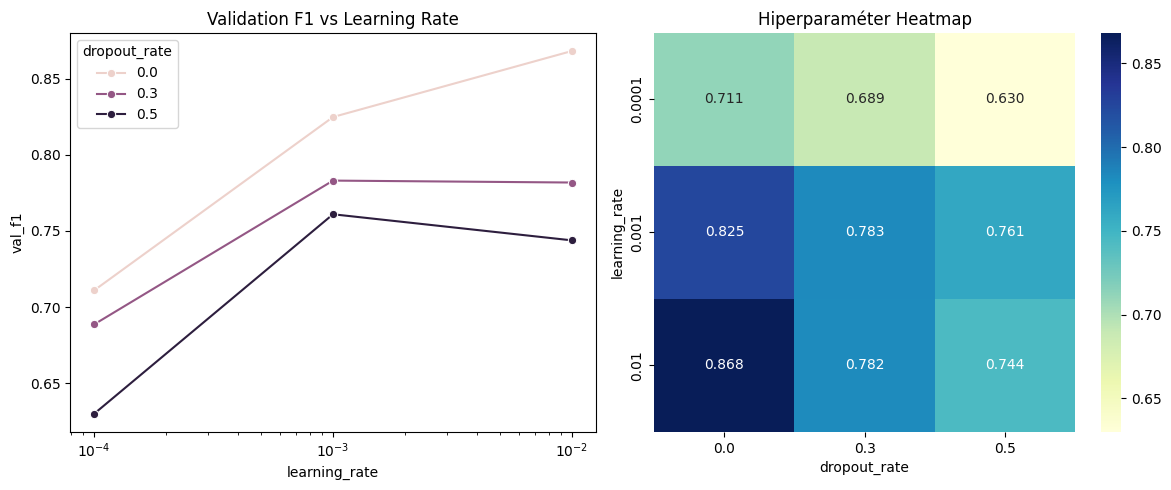

In [36]:
visualize_results(results)

### Evaluation on a longer run for given parameter

In [37]:
optimized_model1 = DDoSDetector(
    learning_rate=1e-3,
    dropout_rate=0.0
)

optimized_model1_trainer = pl.Trainer(
    max_epochs=10,
    accelerator='auto',
    devices='auto',
    callbacks=[
        pl.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min'),
        pl.callbacks.ModelCheckpoint(monitor='val_loss', mode='min'),
        pl.callbacks.LearningRateMonitor(logging_interval='epoch')
    ]
)

optimized_model1_trainer.fit(optimized_model1, dm_with_c)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type                       | Params | Mode 
----------------------------------------------------------------------
0  | layers        | Sequential                 | 10.1 K | train
1  | train_acc     | MulticlassAccuracy         | 0      | train
2  | val_acc       | MulticlassAccuracy         | 0      | train
3  | val_precision | MulticlassPrecision        | 0      | train
4  | val_recall    | MulticlassRecall           | 0      | train
5  | val_f1        | MulticlassF1Score          | 0      | train
6  | val_roc_auc   | MulticlassAUROC            | 0      | train
7  | val_pr_auc    | MulticlassAv

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [39]:
optimized_model1_result = optimized_model1_trainer.test(optimized_model1, datamodule=dm_with_c)
print(optimized_model1_result)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4210456311702728     │
│          test_f1          │    0.4292078912258148     │
│         test_loss         │    1.2560235261917114     │
│        test_pr_auc        │    0.48327693343162537    │
│       test_roc_auc        │     0.776954174041748     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.2560235261917114, 'test_acc': 0.4210456311702728, 'test_f1': 0.4292078912258148, 'test_roc_auc': 0.776954174041748, 'test_pr_auc': 0.48327693343162537}]


In [38]:
import itertools

In [40]:
def manual_hyperparameter_tune(data_module):
    learning_rates = [1e-2, 1e-3, 1e-4]
    # dropout_rates = [0.0, 0.3, 0.5]
    # batch_sizes = [32, 64, 128]
    hidden_size = [64, 128, 256]

    results = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Progress bar
    """
    pbar = tqdm(total=len(learning_rates)*len(dropout_rates), desc="Optimalizalas")

    for lr in learning_rates:
        for dropout in dropout_rates:
            model = DDoSDetector(
                learning_rate=lr,
                dropout_rate=dropout
            ).to(device)

            # Trainer konfigurálása
            trainer = pl.Trainer(
                max_epochs=5,
                enable_progress_bar=True,
                logger=False,
                callbacks=[
                    pl.callbacks.EarlyStopping(
                        monitor="val_f1",
                        patience=3,
                        mode="max"
                    )
                ],
                accelerator="auto"
            )

            dm = data_module

            trainer.fit(model, dm)

            results.append({
                "learning_rate": lr,
                "dropout_rate": dropout,
                "val_f1": trainer.callback_metrics["val_f1"].item(),
                "final_val_loss": trainer.callback_metrics["val_loss"].item()
            })

            pbar.update(1)
    """
    pbar = tqdm(total=len(learning_rates)*len(hidden_size), desc="Semi-automated optimalization")

    for learning_rate in learning_rates:
        for hidden in hidden_size:
            # Modell init
            model = DDoSDetector(
                learning_rate=learning_rate,
                hidden_size=hidden
            ).to(device)

            trainer = pl.Trainer(
                max_epochs=3,
                enable_progress_bar=True,
                logger=False,
                callbacks=[
                    pl.callbacks.EarlyStopping(
                        monitor="val_f1",
                        patience=3,
                        mode="max"
                    )
                ],
                accelerator="auto"
            )

            dm = data_module

            trainer.fit(model, dm)

            results.append({
                "learning_rate": learning_rate,
                "hidden_size": hidden,
                "val_f1": trainer,
                "val_f1": trainer.callback_metrics["val_f1"].item(),
                "final_val_loss": trainer.callback_metrics["val_loss"].item()
            })

            pbar.update(1)

    pbar.close()
    return pd.DataFrame(results)

In [41]:
results = manual_hyperparameter_tune(dm_with_c)

Semi-automated optimalization:   0%|          | 0/9 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type                       | Params | Mode 
----------------------------------------------------------------------
0  | layers        | Sequential                 | 5.2 K  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
Semi-automated optimalization:  11%|█         | 1/9 [04:09<33:18, 249.84s/it]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type                       | Params | Mode 
-------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
Semi-automated optimalization:  22%|██▏       | 2/9 [08:17<28:59, 248.53s/it]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type                       | Params | Mode 
-------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
Semi-automated optimalization:  33%|███▎      | 3/9 [12:29<25:00, 250.01s/it]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type                       | Params | Mode 
-------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
Semi-automated optimalization:  44%|████▍     | 4/9 [16:37<20:45, 249.17s/it]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type                       | Params | Mode 
-------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
Semi-automated optimalization:  56%|█████▌    | 5/9 [20:48<16:40, 250.07s/it]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type                       | Params | Mode 
-------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
Semi-automated optimalization:  67%|██████▋   | 6/9 [24:59<12:31, 250.34s/it]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type                       | Params | Mode 
-------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
Semi-automated optimalization:  78%|███████▊  | 7/9 [29:08<08:19, 249.80s/it]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type                       | Params | Mode 
-------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
Semi-automated optimalization:  89%|████████▉ | 8/9 [33:20<04:10, 250.68s/it]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type                       | Params | Mode 
-------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
Semi-automated optimalization: 100%|██████████| 9/9 [37:30<00:00, 250.09s/it]


In [46]:
def visualize_results(df):
    plt.figure(figsize=(12, 5))

    # lineploit for learning rate and validation F1-score, colored by hidden-size
    plt.subplot(1, 2, 1)
    sns.lineplot(data=df, x='learning_rate', y='val_f1', hue='hidden_size', marker='o')
    plt.xscale('log')
    plt.title('Validation F1-score vs learning Rate')

    # Heatmap: Learning rate and hidden size interaction
    plt.subplot(1, 2, 2)
    sns.heatmap(
        df.pivot_table(index='learning_rate', columns='hidden_size', values='val_f1'),
        annot=True, fmt=".3f", cmap="YlGnBu"
    )
    plt.title('Learning Rate vs hidden layer size heatmap')

    plt.tight_layout()
    plt.savefig('hyperparam_results.png')

In [47]:
print(results)

   learning_rate  hidden_size    val_f1  final_val_loss
0         0.0100           64  0.753735        0.198796
1         0.0100          128  0.765722        0.177767
2         0.0100          256  0.814577        0.148987
3         0.0010           64  0.718673        0.222203
4         0.0010          128  0.770490        0.198209
5         0.0010          256  0.774690        0.183423
6         0.0001           64  0.600467        0.312795
7         0.0001          128  0.630931        0.290248
8         0.0001          256  0.673665        0.269941


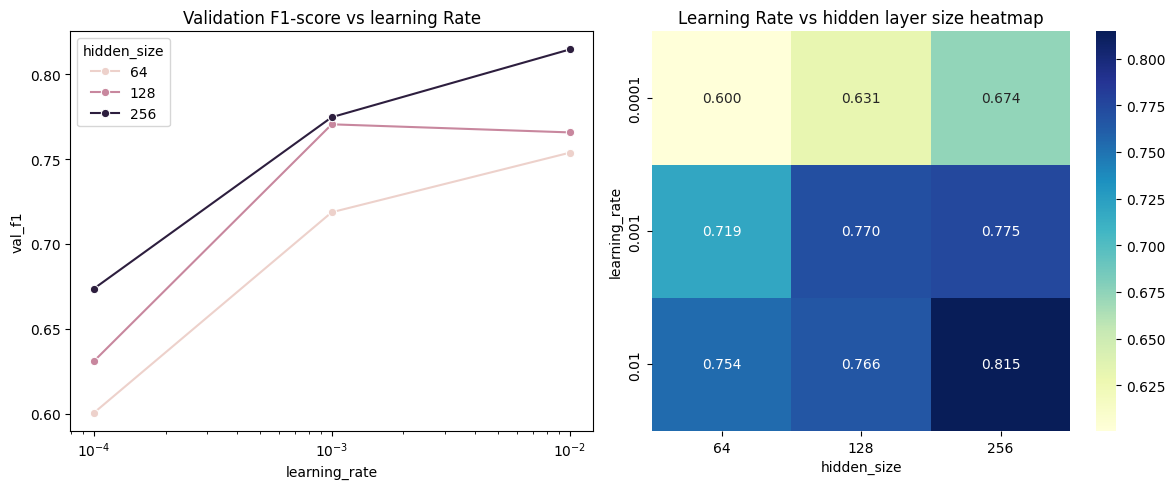

In [48]:
visualize_results(results)